In [3]:
#Importing all the necessary modules.
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
from itertools import chain
from tqdm import tqdm
from vtkplotter import *


In [4]:
train_dir = 'D:/osic-pulmonary-fibrosis-progression/train/'
working_path = 'D:/osic-pulmonary-fibrosis-progression/Dicom_Analysis_Part_2/working_path/'
train_patient_ids=[]
files = []
for root,dirs,filenames in os.walk(train_dir):
    train_patient_ids.extend(dirs)
for i in train_patient_ids:
    path = train_dir + i
    files.append([train_dir + i for i in os.listdir(path)])
#files is a 2-d list holding the exact path of the dicom files. This will be used to understand the hound values.

In [5]:
#Displaying Houndfeld Units

files_1d = list(chain.from_iterable(files)) #Flattening of list.
#print(len(files_1d)) 

In [6]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618'] #Bad Encoding

image_data = []
for patient_id in tqdm(train_patient_ids[10:11]):
    if patient_id  in BAD_ID:
        continue
    path = train_dir + patient_id   
    #Adding metadata Slice Thickness to all the slices
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber)) 
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = slices[0].SliceThickness
    for s in slices:
        s.SliceThickness = slice_thickness
    imgs = get_pixels_hu(slices)
    image_data.append(imgs)

100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


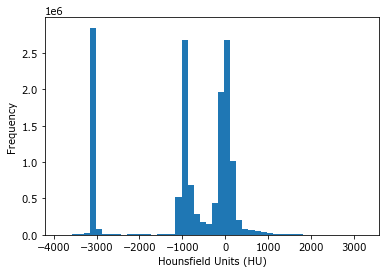

In [7]:
imgs_to_process = image_data
plt.hist(np.array(imgs_to_process).flatten(), bins=50)
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

### As we can see there are a lot of entities present in the lungs, we may need to remove them.

24


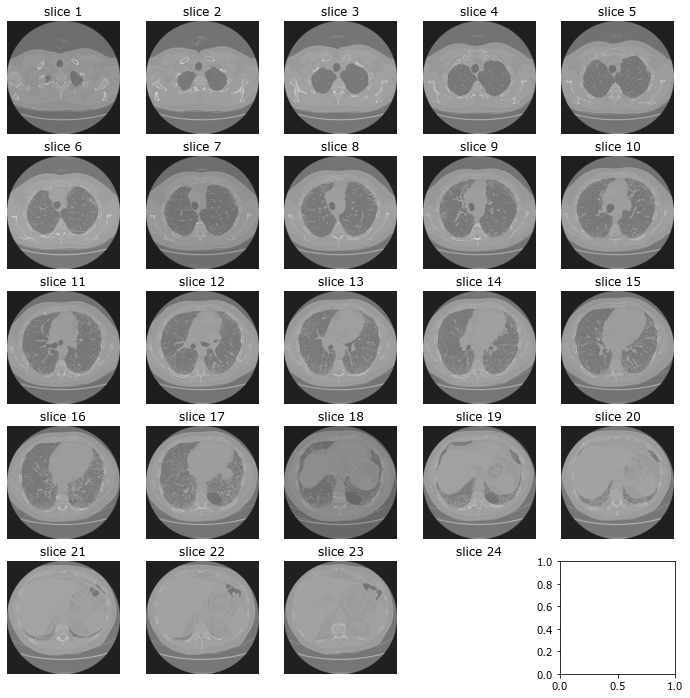

In [8]:
def sample_stack(stack, rows=5, cols=5, start_with=1, show_every=1):
    print(len(stack))
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(len(stack)):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        try:
            ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        except:
            pass
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(np.array(imgs_to_process[0]))  

# Resampling

### Although we have each individual slices, it is not immediately clear how thich each slice is.

In [9]:
test_scan = pydicom.read_file('../train/ID00007637202177411956430/1.dcm')
print(test_scan.SliceThickness)
print("Pixel Spacing: (row , column) ({row} , {col})".format(row=test_scan.PixelSpacing[0],col=test_scan.PixelSpacing[1]) )

1.250000
Pixel Spacing: (row , column) (0.652344 , 0.652344)


In [10]:
#Standardize the pixel values
def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img

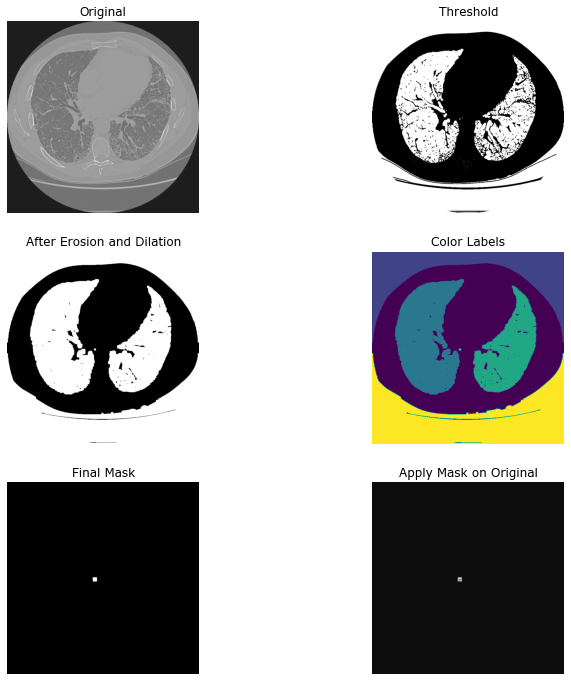

array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])

In [15]:
make_lungmask(imgs_to_process[0][15],display=True)